# Using the `ncbi.datasets` python library to navigate NCBI assembly data

The `ncbi.datasets` python library can be used to query NCBI datasets and navigate through the results quickly within python. 

In [1]:
import sys
import zipfile
import pandas as pd
from pprint import pprint
from datetime import datetime
from collections import defaultdict, Counter
from IPython.display import display

import matplotlib.pyplot as plt
plt.style.use('ggplot')

try:
    import ncbi.datasets
except ImportError:
    print('ncbi.datasets module not found. To install, run `pip install ncbi-datasets-pylib`.')

In [2]:
## start an api_instance 
api_instance = ncbi.datasets.AssemblyDatasetDescriptorsApi(ncbi.datasets.ApiClient())

## Assembly Descriptions

Assembly descriptions can be downloaded using one of the following as queries:
1. accession - an NCBI Assembly accession
2. organism - an organism or a taxonomical group name 
3. taxid - using an NCBI Taxonomy identifier

### Assembly descriptions by accession

In [3]:
assembly_accession = 'GCF_000001405.39' ## needs to be a full accession.version
limit = '10' ## can only use either 'limit' or 'cutoff' but not both
filters_refseq_only = True
tax_exact_match = True

api_response = api_instance.assembly_descriptors_by_accession(
    assembly_accession,
    limit=limit,
    filters_refseq_only=filters_refseq_only,
    tax_exact_match=tax_exact_match)

`api_response` contains a description about the assembly and the total count of results in json format as shown below. 

In [4]:
print(api_response)

{'datasets': [{'annotation_metadata': {'file': [{'estimated_size': '49381805',
                                                 'type': 'GENOME_GFF'},
                                                {'estimated_size': '1315238674',
                                                 'type': 'GENOME_GBFF'},
                                                {'estimated_size': '117125853',
                                                 'type': 'RNA_FASTA'},
                                                {'estimated_size': '26162781',
                                                 'type': 'PROT_FASTA'}],
                                       'name': 'NCBI Annotation Release '
                                               '109.20200228',
                                       'release_date': 'Feb 28, 2020',
                                       'release_number': '109.20200228',
                                       'report_url': 'https://www.ncbi.nlm.nih.gov/genome/annotation_euk/Homo_s

In [5]:
## print total count
total_count = api_response.total_count
print(f"Number of assemblies: {total_count}" )

Number of assemblies: 1


In [6]:
## print other information 
for d in api_response.datasets:
    print(d.assembly_accession, d.assembly_level, len(d.chromosomes), d.submission_date, sep = '\t')

GCF_000001405.39	Chromosome	26	2019-02-28


### Assembly descriptions by organism or tax group name 

In [7]:
## a few examples to try 
# tax_name = 'mammals'
# tax_name = 'birds'
# tax_name = 'butterflies'
tax_name = 'primates'

In [8]:
api_response = api_instance.assembly_descriptors_by_organism(
    tax_name = tax_name,
    limit = 'all')

In [9]:
## total count of results
total_count = api_response.total_count
print(f"Number of assemblies in the group '{tax_name}': {total_count}")

Number of assemblies in the group 'primates': 231


In [10]:
## count number of GenBank and RefSeq assemblies
assm_counter = Counter()
for d in api_response.datasets:
    if d.assembly_accession[:3] == 'GCA':
        assm_counter['GenBank'] += 1
    elif d.assembly_accession[:3] == 'GCF':
        assm_counter['RefSeq'] += 1
    
print(assm_counter)

Counter({'GenBank': 202, 'RefSeq': 29})


,count
GenBank,202
RefSeq,29


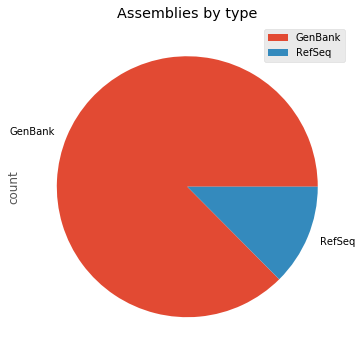

In [11]:
df = pd.DataFrame.from_dict(assm_counter, orient='index', columns=['count'])
display(df)
df.plot(kind='pie', y='count', figsize=(6,6), title='Assemblies by type')

In [12]:
## or the number of assembly levels
assm_level = Counter()
for d in api_response.datasets:
    assm_level[d.assembly_level] += 1
    
print(assm_level)

Counter({'Scaffold': 111, 'Chromosome': 63, 'Contig': 57})


,count
Scaffold,111
Chromosome,63
Contig,57


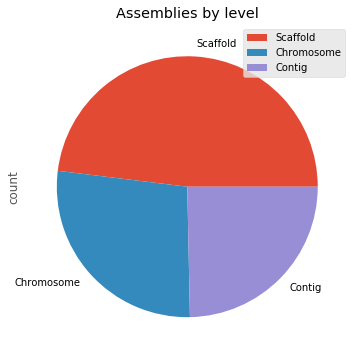

In [13]:
df = pd.DataFrame.from_dict(assm_level, orient='index', columns=['count'])
display(df)
df.plot(kind='pie', y='count', figsize=(6,6), title='Assemblies by level',)

All RefSeq assemblies are annotated and each annotation release is numbered, starting from 100. A quick way to check if the latest annotation is the first time an assembly for that organism was annotated is to check the annotation release number. Anything above 100 can be interpreted to have been through multiple annotations. 

For example, in the analysis shown below, the human assembly has an annotation release number 109 indicating that a human assembly was annotated multiple times. On the other hand, 'silvery gibbon' assembly has an annotation release number 100 indicating that this is the first time an assembly from this organism was annotated. 

In [14]:
## out of the 28 RefSeq assemblies, how many have been annotated more than once? 
annot_counter = Counter()
for d in api_response.datasets:
    if d.assembly_accession.startswith('GCF') and d.annotation_metadata:
        rel = int(d.annotation_metadata.release_number.split('.')[0])
        annot_counter[rel] += 1
pprint(annot_counter)

Counter({100: 9, 101: 8, 103: 4, 102: 3, 104: 2, 105: 1, 109: 1})


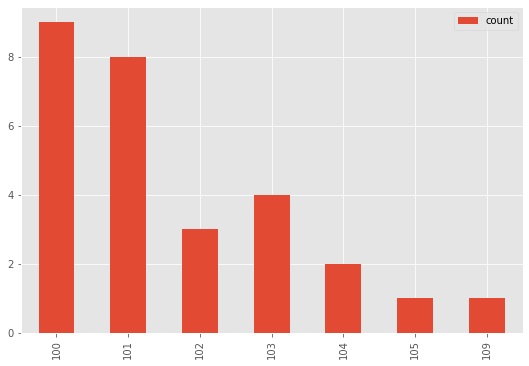

In [15]:
df = pd.DataFrame.from_dict(annot_counter, orient='index', columns=['count']).sort_index()
df.plot(kind='bar', y='count', figsize=(9,6))

In [16]:
annot_list = defaultdict(list)
for d in api_response.datasets:
    if d.assembly_accession.startswith('GCF') and d.annotation_metadata:
        rel = d.annotation_metadata.release_number
        annot_list[rel].append(d.assembly_accession + ' ' + d.org.title)
pprint(annot_list)

defaultdict(<class 'list'>,
            {'100': ['GCF_009761245.1 Tufted capuchin',
                     'GCF_000955945.1 sooty mangabey',
                     'GCF_003255815.1 gelada',
                     'GCF_000951045.1 drill',
                     "GCF_009764315.1 Francois's langur",
                     'GCF_001698545.1 black snub-nosed monkey',
                     'GCF_000951035.1 Colobus angolensis palliatus',
                     "GCF_000956105.1 Coquerel's sifaka",
                     'GCF_001604975.1 Cebus capucinus imitator'],
             '101': ['GCF_000364345.1 crab-eating macaque',
                     'GCF_000956065.1 pig-tailed macaque',
                     'GCF_000165445.2 gray mouse lemur',
                     "GCF_000952055.2 Ma's night monkey",
                     'GCF_000235385.1 Bolivian squirrel monkey',
                     'GCF_007565055.1 golden snub-nosed monkey',
                     'GCF_009828535.2 silvery gibbon',
                     'GCF_00016480

### Assembly descriptions by taxid

In [17]:
# taxid = 8782 ## birds
# taxid = 7898 ## ray-finned fish
taxid = 37572 ## butterflies

In [18]:
api_response = api_instance.assembly_descriptors_by_taxid(
    tax_id = taxid,
    limit = 'all',
    filters_refseq_only = True)

In [19]:
## total count of results
total_count = api_response.total_count
print(f"Number of assemblies: {total_count}")

Number of assemblies: 7


In [20]:
## count number of GenBank and RefSeq assemblies
## all are RefSeq assemblies because 'filters_refseq_only=True' above
assm_counter = Counter()
for d in api_response.datasets:
    assm_counter[d.assembly_accession[:3]] += 1
    
print(assm_counter)

Counter({'GCF': 7})


In [21]:
annot_rel_dates = Counter()
for d in api_response.datasets:
    if d.assembly_accession.startswith('GCF'): 
        rel_date = datetime.strptime(d.annotation_metadata.release_date, '%b %d, %Y')
        rel_year = datetime.strftime(rel_date, '%Y')
        annot_rel_dates[rel_year] += 1
pprint(sorted(annot_rel_dates.items()))

[('2015', 3), ('2017', 1), ('2018', 2), ('2020', 1)]


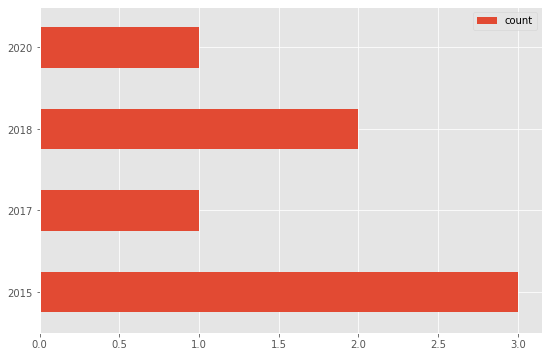

In [22]:
df = pd.DataFrame.from_dict(annot_rel_dates, orient='index', columns=['count']).sort_index()
df.plot(kind='barh', y='count', figsize=(9,6))

In [23]:
assm_table = {}
for d in api_response.datasets:
    n_chr = len(d.chromosomes) if d.assembly_level == 'Chromosome' else None
    assm_table[d.assembly_accession] = {
        'assm_name': d.display_name,
        'annot_rel_date': d.annotation_metadata.release_date,
        'annot_rel_num': d.annotation_metadata.release_number,
        'assm_level': d.assembly_level,
        'num_chromosomes': n_chr,
        'contig_n50': d.contig_n50,
        'seq_length': d.seq_length,
        'submission_date': d.submission_date }
df = pd.DataFrame.from_dict(assm_table, orient='columns')
display(df)

,GCF_001856805.1,GCF_000836235.1,GCF_001298355.1,GCF_000836215.1,GCF_900239965.1,GCF_009731565.1,GCF_002938995.1
assm_name,P_rapae_3842_assembly_v2,Pxut_1.0,Pap_ma_1.0,Ppol_1.0,Bicyclus_anynana_v1.2,Dplex_v4,ASM293899v1
annot_rel_date,"Aug 08, 2017","Jul 31, 2015","Oct 28, 2015","Jul 30, 2015","Feb 16, 2018","Feb 24, 2020","Oct 03, 2018"
annot_rel_num,100,100,100,100,100,100,100
assm_level,Scaffold,Scaffold,Scaffold,Scaffold,Scaffold,Chromosome,Scaffold
num_chromosomes,None,None,None,None,None,31,None
contig_n50,54957,128246,92238,47768,78697,108026,254123
seq_length,245871251,243890167,278421261,227005758,475399557,248676414,357124929
submission_date,2016-10-16,2015-02-02,2015-09-28,2015-02-02,2018-01-02,2019-12-11,2018-02-23


## Assembly downloads

In [24]:
dl_instance = ncbi.datasets.DownloadApi(ncbi.datasets.ApiClient())

In [25]:
assembly_accessions = ['GCF_000001405.39']
chromosomes = ['MT']
include_sequence = True
include_annotation_type = ['RNA_FASTA', 'PROT_FASTA']
try:
    # Retrieve a requested dataset and stream back reply by assembly accession
    api_response = dl_instance.download_assembly_package(
        assembly_accessions,
        chromosomes=chromosomes,
        include_sequence=include_sequence,
        _preload_content=False,
        include_annotation_type=include_annotation_type
    )
    with open('human_assembly.zip', 'wb') as f:
        f.write(api_response.data)
except ncbi.datasets.ApiException as e:
    print("Exception when calling DownloadApi->download_package: %s\n" % e)

In [26]:
!unzip -v human_assembly.zip

Archive:  human_assembly.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
      57  Defl:N       59  -4% 04-09-2020 13:23 b0865ddc  ncbi_dataset/bagit.txt
     998  Defl:N      515  48% 04-09-2020 13:23 64ffaf9b  README.md
    1912  Defl:N      878  54% 04-09-2020 13:23 c3150e75  ncbi_dataset/data/GCF_000001405.39/data_report.yaml
   16834  Defl:N     5379  68% 04-09-2020 13:23 932c3ae8  ncbi_dataset/data/GCF_000001405.39/chrMT.fna
603050508  Defl:N 117125835  81% 04-09-2020 13:23 211c1695  ncbi_dataset/data/GCF_000001405.39/rna.fna
84547070  Defl:N 26162763  69% 04-09-2020 13:23 7a138380  ncbi_dataset/data/GCF_000001405.39/protein.faa
     523  Defl:N      170  68% 04-09-2020 13:23 d2edd9f2  ncbi_dataset/data/dataset_catalog.json
       0  Defl:N        2   0% 04-09-2020 13:23 00000000  ncbi_dataset/fetch.txt
     122  Defl:N      117   4% 04-09-2020 13:23 40153352  ncbi_dataset/bag-info.txt
     311  Def

## Combining Assembly descriptions and downloads

1. Fetch a list of RefSeq assembly accessions for all bird genomes using `assembly_descriptors_by_taxid` 
2. Filter assemblies that were annotated in 2019
3. Download data

In [27]:
api_response = api_instance.assembly_descriptors_by_taxid(
    tax_id = 9989, ## taxid 9989 is 'rodents'
    limit = 'all',
    filters_refseq_only = True)

In [28]:
print(api_response.total_count)

28


In [29]:
annots_by_year = Counter()
for d in api_response.datasets:
    annot_year = int(d.annotation_metadata.release_date.split(' ')[-1])
    annots_by_year[annot_year] += 1
    
pprint(sorted(annots_by_year.items()))

[(2015, 3), (2016, 5), (2017, 5), (2018, 6), (2019, 8), (2020, 1)]


In [30]:
assm_accs = []
for d in api_response.datasets:
    annot_year = int(d.annotation_metadata.release_date.split(' ')[-1])
    if annot_year == 2019:
        assm_accs.append(d.assembly_accession)
        
print(assm_accs)

['GCF_004664715.1', 'GCF_900094665.1', 'GCF_000001635.26', 'GCF_900095145.1', 'GCF_008632895.1', 'GCF_003676075.1', 'GCF_004785775.1', 'GCF_000622305.1']


In [31]:
assm_table = {}
for d in api_response.datasets:
    annot_year = int(d.annotation_metadata.release_date.split(' ')[-1])
    if annot_year == 2019:
        n_chr = len(d.chromosomes) if d.assembly_level == 'Chromosome' else None
        assm_table[d.assembly_accession] = {
            'assm_name': d.display_name,
            'org_name': d.org.title,
            'sci_name': d.org.sci_name,
            'annot_rel_date': d.annotation_metadata.release_date,
            'annot_rel_num': d.annotation_metadata.release_number,
            'assm_level': d.assembly_level,
            'num_chromosomes': n_chr,
            'contig_n50': d.contig_n50,
            'seq_length': d.seq_length,
            'submission_date': d.submission_date }
df = pd.DataFrame.from_dict(assm_table, orient='columns')
display(df)

,GCF_004664715.1,GCF_900094665.1,GCF_000001635.26,GCF_900095145.1,GCF_008632895.1,GCF_003676075.1,GCF_004785775.1,GCF_000622305.1
assm_name,Pero_0.1,CAROLI_EIJ_v1.1,GRCm38.p6,PAHARI_EIJ_v1.1,UCSF_Mcou_1,ASM367607v1,NIH_TR_1.0,S.galili_v1.0
org_name,white-footed mouse,Ryukyu mouse,house mouse,shrew mouse,southern multimammate mouse,yellow-bellied marmot,Grammomys surdaster,Upper Galilee mountains blind mole rat
sci_name,Peromyscus leucopus,Mus caroli,Mus musculus,Mus pahari,Mastomys coucha,Marmota flaviventris,Grammomys surdaster,Nannospalax galili
annot_rel_date,"Apr 18, 2019","Jun 07, 2019","Jul 12, 2019","Jun 14, 2019","Oct 18, 2019","Jan 25, 2019","Apr 18, 2019","Jun 05, 2019"
annot_rel_num,100,101,108,101,100,100,100,102
assm_level,Scaffold,Chromosome,Chromosome,Chromosome,Chromosome,Scaffold,Scaffold,Scaffold
num_chromosomes,None,22,23,25,4,None,None,None
contig_n50,4102727,30917,32813180,29465,30483,130359,51731,30353
seq_length,2474055010,2553112587,2730855475,2475012951,2507168619,2582142248,2412664998,3061408210
submission_date,2019-04-05,2017-04-28,2017-09-15,2017-04-28,2019-09-24,2018-10-22,2019-04-12,2014-06-05


In [32]:
dl_response = dl_instance.download_assembly_package(
    assm_accs,
    include_sequence=False,
    _preload_content=False )

with open('rodent_genomes.zip', 'wb') as f:
    f.write(dl_response.data)

In [97]:
!unzip -v rodent_genomes.zip

Archive:  rodent_genomes.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
      57  Defl:N       59  -4% 04-09-2020 12:27 b0865ddc  ncbi_dataset/bagit.txt
     998  Defl:N      515  48% 04-09-2020 12:27 64ffaf9b  README.md
   17531  Defl:N     2435  86% 04-09-2020 12:27 130138ed  ncbi_dataset/data/GCF_000001635.26/data_report.yaml
31460871  Defl:N  1156294  96% 04-09-2020 12:27 f3d750ce  ncbi_dataset/data/GCF_000622305.1/data_report.yaml
 6698440  Defl:N   327968  95% 04-09-2020 12:28 c7a633ed  ncbi_dataset/data/GCF_003676075.1/data_report.yaml
  365280  Defl:N    20883  94% 04-09-2020 12:28 0ffcec1d  ncbi_dataset/data/GCF_004664715.1/data_report.yaml
 4832084  Defl:N   232241  95% 04-09-2020 12:28 f32b8c64  ncbi_dataset/data/GCF_004785775.1/data_report.yaml
    7989  Defl:N     1535  81% 04-09-2020 12:28 fe541d7e  ncbi_dataset/data/GCF_008632895.1/data_report.yaml
  652020  Defl:N    33899  95% 04-09-2020